# Week 9 Assignment: NLP Text classification

Create a NLP text classifier to predict whether a text message is spam. 

1) Load the dataset which includes 2 fields: (text and label) where label  indicates whether the message is “spam” or "not spam"  (eg: ham).

2) Perform basic EDA

3) Perform preprocessing of text (eg: lower-case, tokenization, removal of stop words, stemming/lemmatization, etc. as needed)

4) Vectorize Text (eg: BoW, TF-IDF, etc)

5) Create a model, using at least 2 different ML algorithms
    
 * Split the data into training and testing set
 * Train the model on training, then predict and assess performance on test
 * predict custom messages (eg: your own custom message, at least 3) to evaluate how well your model categorized it

In [32]:
import numpy as np
import pandas as pd
import string
import re
import itertools
import random

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk import NaiveBayesClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("spam.csv")

In [3]:
# Make a copy without any transformations for us with Sklearn
df_clean = df.copy()

In [5]:
# Add a length of text column before the cleaning
df['length'] = df.apply(lambda row: len(row.text), axis = 1)

## Data Cleaning

Perform the following transfermations

1. Replace the output variables of `ham` and `spam` with `1` and `0`
2. Covert all text to lowercase
3. Remove puncutation
4. Tokenize the words
5. Stemm the words

In [6]:
# Replace the text based labels with 1 and 0
df['label'] = df.label.map({'ham': 0, 'spam': 1})
# Convert all to lowercase
df['text'] = df.text.map(lambda x: x.lower())
# Remove punctuation
df['text'] = df.text.str.replace('[^\w\s]', '', regex=True)
# Tokenize the words
df['text'] = df['text'].apply(word_tokenize)
# Stem the tokenized words
stemmer = PorterStemmer() 
df['text'] = df['text'].apply(lambda x: [stemmer.stem(y) for y in x])

In [7]:
# Add a length of text column
df['tok_length'] = df.apply(lambda row: len(row.text), axis = 1)

In [8]:
df.head()

,label,text,length,tok_length
0,0,"[go, until, jurong, point, crazi, avail, onli,...",111,20
1,0,"[ok, lar, joke, wif, u, oni]",29,6
2,1,"[free, entri, in, 2, a, wkli, comp, to, win, f...",155,28
3,0,"[u, dun, say, so, earli, hor, u, c, alreadi, t...",49,11
4,0,"[nah, i, dont, think, he, goe, to, usf, he, li...",61,13


In [9]:
df.tail()

,label,text,length,tok_length
5567,1,"[thi, is, the, 2nd, time, we, have, tri, 2, co...",161,30
5568,0,"[will, ì_, b, go, to, esplanad, fr, home]",37,8
5569,0,"[piti, wa, in, mood, for, that, soani, other, ...",57,9
5570,0,"[the, guy, did, some, bitch, but, i, act, like...",125,26
5571,0,"[rofl, it, true, to, it, name]",26,6


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5572 non-null   int64 
 1   text        5572 non-null   object
 2   length      5572 non-null   int64 
 3   tok_length  5572 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 174.2+ KB


In [11]:
df.describe()

,label,length,tok_length
count,5572.000000,5572.000000,5572.000000
mean,0.134063,80.118808,15.297559
std,0.340751,59.690841,11.089433
min,0.000000,2.000000,0.000000
25%,0.000000,36.000000,7.000000
50%,0.000000,61.000000,12.000000
75%,0.000000,121.000000,22.000000
max,1.000000,910.000000,171.000000


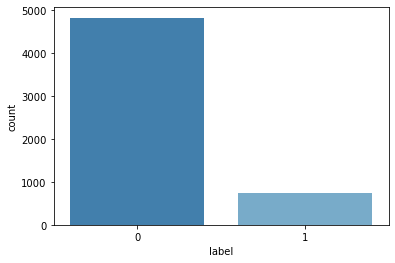

In [12]:
sns.countplot(x=df['label'], palette="tab20c");

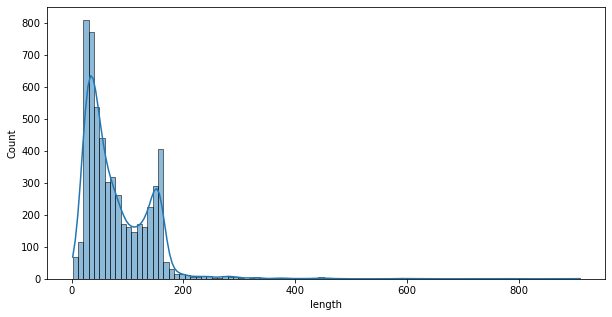

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='length', kde=True, palette="tab20c");

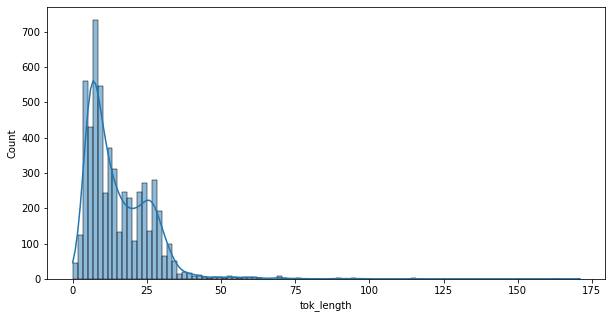

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(df, x='tok_length', kde=True, palette="tab10");

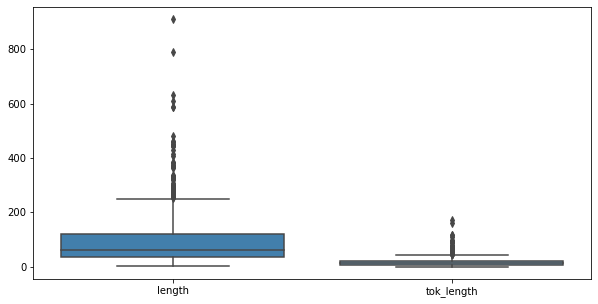

In [21]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['length', 'tok_length']], palette="tab20c");

In [23]:
# Change the order of the columns and remove anything we don't need post analysis.
df = df[['text', 'label']].copy()
df

,text,label
0,"[go, until, jurong, point, crazi, avail, onli,...",0
1,"[ok, lar, joke, wif, u, oni]",0
2,"[free, entri, in, 2, a, wkli, comp, to, win, f...",1
3,"[u, dun, say, so, earli, hor, u, c, alreadi, t...",0
4,"[nah, i, dont, think, he, goe, to, usf, he, li...",0
...,...,...
5567,"[thi, is, the, 2nd, time, we, have, tri, 2, co...",1
5568,"[will, ì_, b, go, to, esplanad, fr, home]",0
5569,"[piti, wa, in, mood, for, that, soani, other, ...",0
5570,"[the, guy, did, some, bitch, but, i, act, like...",0


## NLTK Version

In [24]:
# build a bad of words...
def build_bag_of_words_features(words):
    return {word:1 for word in words}

In [25]:
# Extract only Ham
df_ham = df[df['label'] == 0]

# builds a list of positive reviews words/features with stop words and punction removed
ham_features = [(build_bag_of_words_features(x), 'ham')
               for x in df_ham['text']]

print(ham_features[0])
print(ham_features[1])

({'go': 1, 'until': 1, 'jurong': 1, 'point': 1, 'crazi': 1, 'avail': 1, 'onli': 1, 'in': 1, 'bugi': 1, 'n': 1, 'great': 1, 'world': 1, 'la': 1, 'e': 1, 'buffet': 1, 'cine': 1, 'there': 1, 'got': 1, 'amor': 1, 'wat': 1}, 'ham')
({'ok': 1, 'lar': 1, 'joke': 1, 'wif': 1, 'u': 1, 'oni': 1}, 'ham')


In [26]:
len(ham_features)

4825

In [27]:
# Extract only SPAM
df_spam = df[df['label'] == 1]

# builds a list of negative reviews words/features with stop words and punction removed
spam_features = [(build_bag_of_words_features(x), 'spam')
                 for x in df_spam['text']]

print(spam_features[0])
print(spam_features[1])

({'free': 1, 'entri': 1, 'in': 1, '2': 1, 'a': 1, 'wkli': 1, 'comp': 1, 'to': 1, 'win': 1, 'fa': 1, 'cup': 1, 'final': 1, 'tkt': 1, '21st': 1, 'may': 1, '2005': 1, 'text': 1, '87121': 1, 'receiv': 1, 'questionstd': 1, 'txt': 1, 'ratetc': 1, 'appli': 1, '08452810075over18': 1}, 'spam')
({'freemsg': 1, 'hey': 1, 'there': 1, 'darl': 1, 'it': 1, 'been': 1, '3': 1, 'week': 1, 'now': 1, 'and': 1, 'no': 1, 'word': 1, 'back': 1, 'id': 1, 'like': 1, 'some': 1, 'fun': 1, 'you': 1, 'up': 1, 'for': 1, 'still': 1, 'tb': 1, 'ok': 1, 'xxx': 1, 'std': 1, 'chg': 1, 'to': 1, 'send': 1, 'å150': 1, 'rcv': 1}, 'spam')


In [28]:
len(spam_features)

747

In [43]:
split = 500

# split, train, test 

# first 300 for training
train = ham_features[:split] + spam_features[:split]
random.shuffle(train)

sent_classifier = NaiveBayesClassifier.train(train)

In [44]:
print('num features for train: ', len(train))

nltk.classify.util.accuracy(sent_classifier, train)*100

num features for train:  1000


97.5

In [45]:
# remaining for test
test = ham_features[split:] + spam_features[split:]

print('num features for test: ', len(test))

nltk.classify.util.accuracy(sent_classifier, test)*100

num features for test:  4572


88.18897637795276

In [46]:
sent_classifier.show_most_informative_features()

Most Informative Features
                     txt = 1                spam : ham    =     47.0 : 1.0
                   award = 1                spam : ham    =     25.7 : 1.0
                  custom = 1                spam : ham    =     21.7 : 1.0
                    chat = 1                spam : ham    =     19.7 : 1.0
                    draw = 1                spam : ham    =     18.3 : 1.0
                     ill = 1                 ham : spam   =     17.7 : 1.0
                    cash = 1                spam : ham    =     17.0 : 1.0
                    line = 1                spam : ham    =     17.0 : 1.0
                 contact = 1                spam : ham    =     15.8 : 1.0
                   chanc = 1                spam : ham    =     15.7 : 1.0


### Test with Custom Data

In [47]:
# get the training vocabulary
train_vocab = set()

for t in train:
    vocabDict = t[0]
    for key in vocabDict.keys():
      train_vocab.add(key)
len(train_vocab)

3422

In [48]:
from nltk.tokenize import word_tokenize

docs=["txt us at 8787 for a free trip to hawaii!", 
    "I'm looking forward to when my day is over", 
    "for a free week of mobile service"]

for doc in docs:
     t_features = {word: (word in word_tokenize(doc.lower())) for word in train_vocab}
     print(doc," : ", sent_classifier.classify(t_features)) 

txt us at 8787 for a free trip to hawaii!  :  spam
I'm looking forward to when my day is over  :  ham
for a free week of mobile service  :  spam


# Scikit Learn Version

In [49]:
df = df_clean.copy()

# Set `y` 
y = df.label 

# Drop the `label` column
df.drop("label", axis=1)

# Make training and test sets 
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=53)

In [50]:
print(y_train.shape)
print(X_train.shape)

(3733,)
(3733,)


## Models on Original Dataset

In [51]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english', strip_accents='unicode')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [52]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, strip_accents='unicode') 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [53]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['yuo', 'yuou', 'yup', 'yupz', 'zebra', 'zed', 'zeros', 'zhong', 'zoe', 'zogtorius']
['00', '000', '008704050406', '0089', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400']


In [54]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df

,00,000,008704050406,0089,01223585236,01223585334,0125698789,02,0207,02072069400,...,yuo,yuou,yup,yupz,zebra,zed,zeros,zhong,zoe,zogtorius
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3731,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [55]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df

,00,000,008704050406,0089,01223585236,01223585334,0125698789,02,0207,02072069400,...,yuo,yuou,yup,yupz,zebra,zed,zeros,zhong,zoe,zogtorius
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.266889,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

In [57]:
clf = MultinomialNB() 

              precision    recall  f1-score   support

         ham      0.964     1.000     0.982      1602
        spam      1.000     0.751     0.858       237

    accuracy                          0.968      1839
   macro avg      0.982     0.876     0.920      1839
weighted avg      0.969     0.968     0.966      1839

accuracy:   0.968
Confusion matrix, without normalization


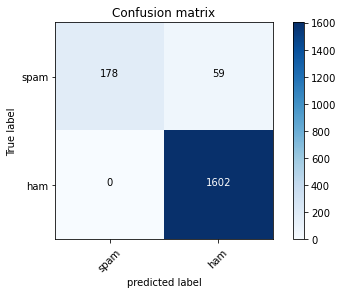

In [60]:
clf.fit(tfidf_train, y_train)
y_pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

In [61]:
clf = MultinomialNB() 

              precision    recall  f1-score   support

         ham      0.991     0.996     0.994      1602
        spam      0.974     0.941     0.957       237

    accuracy                          0.989      1839
   macro avg      0.983     0.969     0.975      1839
weighted avg      0.989     0.989     0.989      1839

accuracy:   0.989
Confusion matrix, without normalization


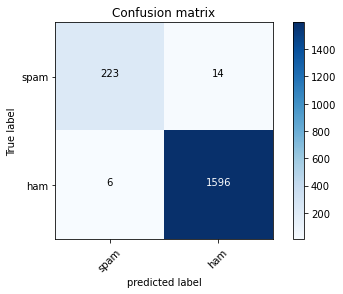

In [62]:
clf.fit(count_train, y_train)
y_pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

### Resample the Minority Class

In [63]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [64]:
# separate minority and majority classes
ham = X[X.label == 'ham']
spam = X[X.label == 'spam']

In [65]:
# upsample minority
spam_upsampled = resample(spam,
                          replace=True, # sample with replacement
                          n_samples=len(ham), # match number in majority class
                          random_state=27) # reproducible results

In [66]:
# combine majority and upsampled minority
upsampled = pd.concat([ham, spam_upsampled])

In [67]:
# check new class counts
upsampled.label.value_counts()

ham     3223
spam    3223
Name: label, dtype: int64

### Post Resampling

In [68]:
# balanced dataset
y_train = upsampled.label
X_train = upsampled.text

In [69]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words='english', strip_accents='unicode')

# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [70]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='unicode') 

# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [71]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['yuo', 'yuou', 'yup', 'yupz', 'zebra', 'zed', 'zeros', 'zhong', 'zoe', 'zogtorius']
['00', '000', '008704050406', '0089', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400']


In [72]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

In [73]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [74]:
clf = MultinomialNB() 

              precision    recall  f1-score   support

         ham      0.990     0.975     0.983      1602
        spam      0.847     0.937     0.890       237

    accuracy                          0.970      1839
   macro avg      0.919     0.956     0.936      1839
weighted avg      0.972     0.970     0.971      1839

accuracy:   0.970
Confusion matrix, without normalization


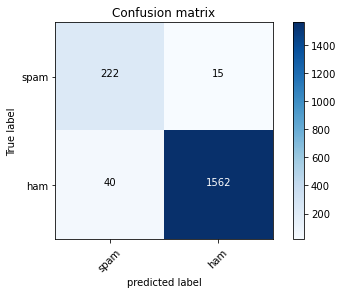

In [75]:
clf.fit(tfidf_train, y_train)
y_pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

In [76]:
clf = MultinomialNB() 

              precision    recall  f1-score   support

         ham      0.991     0.977     0.984      1602
        spam      0.858     0.941     0.897       237

    accuracy                          0.972      1839
   macro avg      0.924     0.959     0.941      1839
weighted avg      0.974     0.972     0.973      1839

accuracy:   0.972
Confusion matrix, without normalization


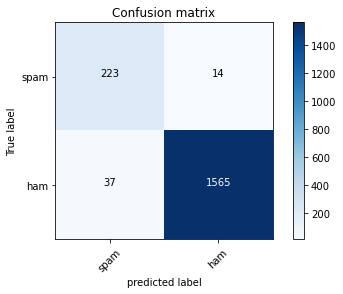

In [77]:
clf.fit(count_train, y_train)
y_pred = clf.predict(count_test)
score = metrics.accuracy_score(y_test, y_pred)

print(metrics.classification_report(y_test, y_pred, digits=3))

print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, y_pred, labels=['spam', 'ham'])
plot_confusion_matrix(cm, classes=['spam', 'ham'])

### Example Spam

In [78]:
a = ["txt us at 8787 for a free trip to hawaii!", 
     "I'm looking forward to when my day is over", 
     "for a free week of mobile service"]

In [79]:
for b in a:
    b_trans = tfidf_vectorizer.transform([b])
    print(clf.predict(b_trans))

['spam']
['ham']
['spam']
